Related tweet: https://twitter.com/sassorgsa/status/1138767881192333313

<div style="text-align:right">
إعداد وكتابة: عبدالعزيز الطويان
<br><a href="https://github.com/iamaziz">@iamaziz</a>
<br><a href="http://aziz.nyc/ar/k_means.slides.html">لعرض الشرائح</a>
<br>6/15/2019
</div>

<div style="text-align:left;font-size:8px">ملاحظة: استخدم مفتاح المسافة على لوحة المفاتيح للتنقل بين الشرائح</div>

# <div dir="rtl" lang="ar">مهمة</div>

<div dir="rtl" lang="ar">لنفترض ان لدينا بيانات عن جميع سكان مدينة الرياض كـ <b>العمر، الوزن، الطول، الراتب</b> (دعنا نسميها بالـ <b>خصائص</b> أو الأبعاد) ونريد القيام بدراسة ما باستخدام هذه البيانات. ولكن لأن عدد السكان كبير جداً، و من أجل تسهيل المهمة، نرغب في تقسيم هذه البيانات إلى عدة مجموعات بحيث أن كل مجموعة ستحتوي على أشخاص متشابهين (أي يملكون خصائص مشابهة).</div>

<div dir="rtl" lang="ar"><b>كيف يمكننا القيام بذلك</b>؟</div>

<div dir="rtl" lang="ar"><b>الجواب</b>: يمكننا استخدام <b>خوارزمية التجميع</b> للقيام بهذه المهمة.</div>

# <div dir="rtl" lang="ar"> خوارزمية التجميع (أو التصنيف) k-means</div>

<div dir="rtl" lang="ar">
    تستخدم هذه الخوارزمية كثيراً في مجال <b>تعلم الآلة</b> و <b>علم البيانات</b> لتجميع "تقسيم" نقاط البيانات المتشابهه (المتقاربة) مع بعضها البعض في عدد معين من المجموعات.
</div>

## <div dir="rtl" lang="ar">كيف تعمل الخوارزمية؟</div>

<div dir="rtl" lang="ar">
فكرة الخوارزمية سهلة جداً. تبدأ بتحديد نقاط منتصف إبتدائية (يمكن إختيارها من البيانات المُدخلة) مع مجوعة فارغة لكل نقطة منتصف. ثم تقوم بالمرور على جميع نقاط البيانات و إضافة كل نقطة من البيانات إلى إحدى المجموعات الفارغة بحسب قُرب مسافتها من نقطة المنتصف لتلك المجموعة.
بعد زيارة كل النقاط، ستصبح المجموعات ليست فارغة و تحتوي على نقاط مضافة، عندها تقوم الخوارزمية بحساب نقطة منتصف جديدة لكل مجموعة مع الأخذ بالإعتبار للنقاط المضافة. الآن، وبعد أن حصلنا على نقاط منتصف جديدة، نقوم بتكرار نفس العلمية مرة أخرى، بمعنى: زيارة جميع نقاط البيانات، إضافة كل نقطة إلى مجموعتها الأقرب، حساب نقاط منتصف جديدة .. الخ. تتكرر هذه العملية حتى تصبح نقاط المنتصف الجديدة هي نفسها السابقة. عندها تتوقف الخوارزمية وتقوم بإرجاع المجموعات النهائية بحيث كل مجموعة تحتوي على نقاط متشابهة. 
</div>

## <div dir="rtl" lang="ar">خطوات الخوارزمية</div>
<br>
<div dir="rtl" lang="ar">
بعد تحديد عدد المجموعات المطلوبة $k$ تقوم الخوارزمية بالخطوات التالية:
</div>

<div dir="rtl" style="font-size:12px">
<ul style="text-align: right;">
    <li>1) إنشاء مجموعات فارغة بعدد المجموعات المطلوبة</li>
    <li>2) إختيار نقاط منتصف أولية (يمكن إختيارها عشوائياً من المدخلات) لكل مجموعة</li>
    <li>3) زيارة كل نقطة من نقاط البيانات:</li>
    <ul style="list-style: number; text-align: right;">
        <li>3.1) حساب المسافة بين هذه النقطة و نقاط المنتصف، مع إختيار المسافة الأقرب</li>
        <li>3.2) إضافة هذه النقطة إلى المجموعة الأقرب لها</li>
    </ul>
    <li>4) بعد إضافة جميع النقاط إلى المجموعات المختلفة، تقوم بحساب نقطة منتصف جديدة لكل مجموعة</li>
    <li>5) اذهب للخطوة 3 وكرر نفس العمليات، حتى تصبح نقاط المنتصف الجديدة هي نفسها السابقة. بمعني المجموعات لا تتغير</li>
    <li>6) إرجاع المجموعات النهائية</li>
</ul>
</div>

## <div dir="rtl" lang="ar">تنويه</div>

<div dir="rtl" lang="ar">
في هذا الشرح، ولغرض تبسيط المفهوم:
</div>
<br>
<div dir="rtl" lang="ar">- سنستخدم عدد صغير من البيانات لشرح كيف تعمل الخوارزمية بالتفصيل.</div>
<div dir="rtl" lang="ar">- سنفترض بيانات وهمية لـ <b>الوزن</b> و <b>الطول</b> لعشرة اشخاص فقط. لاحظ <b>خاصيتين</b> فقط بمعنى كل نقطة في مدخلات البيانات ستحتوي على <b>بعدين</b>. عموماً، الخوارزمية تنطبق على أي عدد من الأبعاد.</div>
<div dir="rtl" lang="ar">- سنستخدم لغة البرمجة بايثون لكتابة هذه الخورازمية.</div>
<div dir="rtl" lang="ar">- سنقوم بكتابة الخوارزمية من الصفر بدون إستخدام أي مكتبات برمجية جاهزة و حتى بدون إستخدام أي `import` من بايثون.</div>

> <div dir="rtl" lang="ar"> ملاحظة: يمكن للبيانات أن تكون عن أي شيئ معين و يمكن ان تحتوي على اكثر من بعد او خاصية، مثلاً: بيانات مرضى، أو قياسات درجات حرارة، أو أسعار اسهم، وغيرها
</div>

<hr>

<div dir="rtl" lang="ar">
دعنا أولاً نبداً بـ بيانات الطول و الوزن للعشرة أشخاص، كالتالي: 

</div>

In [1]:
          #  1    2    3    4    5    6    7    8    9   10     رقم كل شخص 
weights = [ 74,  77,  81,  76,  80,  91,  88,  93,  88,  92] # الوزن بالكيلوغرام
heights = [179, 182, 181, 175, 174, 182, 178, 178, 174, 173] # الطول بالسنتيمتر

In [2]:
# ملاحظة: هذا الكود لمجرد توضيح وعرض البيانات وليس جزء من الشرح، لاتهتم لهذا الكود الآن
%matplotlib inline
import matplotlib.pyplot as plt        # نستدعي مكتبة الرسوم البيانية
from bidi.algorithm import get_display # لعرض النص من اليمين لليسار في الرسم البياني
from arabic_reshaper import reshape    # تنصيص الكلمات العربية

def show_data(): 
    plt.scatter(weights, heights)      # نعطيها بيانات الطول و الوزن X and Y
    w = get_display(reshape(u'الوزن'))
    h = get_display(reshape(u'الطول'))
    plt.grid();plt.xlabel(w);plt.ylabel(h);

<div dir="rtl" lang="ar">
لنتصور البيانات بشكل افضل، سنستعرض النقاط العشرة في الرسم البياني الإحداثي التالي:
</div>

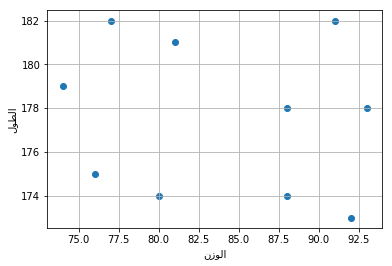

In [3]:
show_data() # هذه الدالة ليست جزء من الشرح، لاتهتم لها الآن

<div dir="rtl" lang="ar">
<meta charset="utf-8">
من اجل تسهيل عملية كتابة الكود، سنضع البيانات في متغير واحد. نسميه الأمثلة. بحيث أن كل مثال سيحتوي على بيانات شخص واحد، كما يلي:
</div>

In [4]:
samples = [list(point) for point in zip(weights, heights)]
samples

[[74, 179],
 [77, 182],
 [81, 181],
 [76, 175],
 [80, 174],
 [91, 182],
 [88, 178],
 [93, 178],
 [88, 174],
 [92, 173]]

<div dir="rtl" lang="ar">
تحتاج خوارزمية التجميع أن تقوم بحساب المسافات بين نقاط البيانات، (وهي المسافة العادية، أي نفس المسافة الناتجة إذا ماستخدمنا المسطرة لحساب المسافة بين نقطتين). تسمى هذه المسافة بـ "المسافة الإقليدية"، ويتم حسابها بين نقطتين $U=(u_1, u_2, ...,u_n)$ و $V=(v_1, v_2, ..., v_n)$ بحيث ان $n$ هو عدد الأبعاد في كل نقطة كما يلي: 
</div>

$$
distance(U, V) = \sqrt{\left(u_{1}-v_{1}\right)^{2}+\left(u_{2}-v_{2}\right)^{2}+\cdots+\left(u_{n}-v_{n}\right)^{2}}=\sqrt{\sum_{i=1}^{n}\left(u_{i}-v_{i}\right)^{2}}
$$

<div dir="rtl" lang="ar">
لذلك  سنحتاج إلى كتابة دالة بايثون لحساب هذه المسافة بين نقطتين (مهما كان عدد الأبعاد في النقطتين) كما يلي:
</div>

In [5]:
def distance(u, v):
    """
    حساب المسافة الإقليدية بين نقطتين
    المسافة = square_root( (u0 - v0)^2 + (u1 - v1)^2) )
    
    u: [int, int], النقطة الأولى
    v: [int, int], النقطة الثانية
    """
    sum_ = sum( (u[i] - v[i])**2 for i in range(len(u)) ) # ناتج الجمع اللي تحت الجذر
    return sum_**(1/2)                                    # نأخذ الجذر للمجموع

<div dir="rtl" lang="ar">
سنكتب دالة تأخذ نقطة معينة (لنسميها النقطة الهدف) مع مجموعة نقاط أخرى (لنسميهم نقاط المنتصف)، وترجع النقطة الأقرب (من نقاط المنتصف) إلى النقطة الهدف. كما يلي:

</div>

In [6]:
def get_closer(target, *args):
    """
    حساب أي النقاط اقرب إلى النقطة الهدف
    
    target:  [float], النقطة الهدف
    *args: [[float]], مجموعة نقاط 
    """
    min_distance = float('inf')      # متغير للمسافة الأقصر، نبدأه بأكبر قيمة  
    for point in args:               # زيارة نقاط المنتصف المدخلة 
        d = distance(point, target)  # حساب المسافة بين الهدف و نقطة المنتصف الحالية
        if d < min_distance:         # إذا كانت المسافة أقصر من المسافة الأقصر السابقة
            min_distance = d         # نحدث متغير المسافة الأقصر للمسافة الحالية
            closer = point           # نحتفط بـ نقطة المنتصف الحالية كالنقطة الأقرب
    return closer                    # بعد مقارنة جميع المسافات، إرجاع النقطة ذات المسافة الأقرب

<div dir="rtl" lang="ar">
<meta charset="utf-8">
اخيراً، سنحتاج دالة أخرى لتقوم بحساب النقطة التي تقع في المنتصف بين مجموعة من النقاط. وهي مجموع النقاط مقسوم على عدد النقاط، تتم كتابتها رياضياً كما يلي بحيث $N$ هو عدد النقاط:
</div>

$$
center = \frac{\sum_{i=1}^{N}u_{i}}{N}
$$

<div dir="rtl" lang="ar">
نستطيع كتابتها في بايثون كما يلي: 
</div>

In [7]:
def get_center(cluster):
    """
    حساب نقطة المنتصف لكل النقاط في المجموعة
    
    cluster: [[float]], قائمة من النقاط
    """
    center = []                             # متغير لتخزين نقطة المنتصف
    n = len(cluster)                        # عدد النقاط في المجموعة
    for i in range(len(cluster[0])):        # عدد الأبعاد في كل نقطة
        c = sum(p[i] for p in cluster) / n  # المجموع لكل بُعد تقسيم عدد النقاط
        center.append(round(c, 1))          # اضف الناتج
    return center                           # إرجاع نقطة المنتصف التي تم حسابها

<div dir="rtl" lang="ar">
الآن وبعد أن قمنا بكتابة كل الدوال البرمجية التي تحتاجها خوارزمية التجميع، نقوم بكتابة الخوارزمية كالآتي:
</div>

In [8]:
def k_means(data, k=2, *centers, verbose=True):
    """
    خوارزمية التجميع "التصنيف" مع تنفيذ بأسلوب التكرار الذاتي
    
    data: [[float]], مجموعة النقاط البيانية التي نرغب في تصنيفها في مجموعات
    k: int, عدد المجموعات التي نرغب بتكوينها
    seeds: [[float]], مُدخل إختياري - نقاط المنتصف (المركزية) الإبتدائية لكل مجموعة
    """
    # نحدد نقاط المنتصف المبدئية إذا كانت لم تدخل مع البيانات
    # عشوائياً نختار من النقاط الأولى في البيانات (بعدد المجموعات)  كنقاط منتصف أولية
    centers = list(centers) if centers else [data[i] for i in range(k)]
        
    clusters = [[] for _ in range(k)] # ننشئ قوائم فارغة لحفظ النقاط التابعة لكل قائمة بها
    
    # نقوم بزيارة جميع النقاط البيانية 
    # ولكل نقطة، سنحسب المسافة بينها وبين نقاط المنتصف  
    for point in data:
        # حساب أي نقاط المنتصف أقرب إلى النقطة البيانية الحالية
        nearest = get_closer(point, *centers)
        # نسترجع عنوان أو دليل (من بين قائمة نقاط المنتصف) نقطة المنتصف الأقرب للنقطة الحالية
        nearest_cluster_index = centers.index(nearest) 
        # نضيف النقطة الحالية إلى قائمة المجموعة التي تتبع لها من بين مجموعة القوائم
        clusters[nearest_cluster_index].append(point)
    # حساب نقاط المنتصف الجديدة
    new_centers = [get_center(cluster) for cluster in clusters]
    # الأمر التالي ليس جزء من الخوارزمية، لمجرد طباعة النتائج المرحلية
    if verbose: print(f"ITER:\tinit cents: {centers}\n\tnew cents: {new_centers}")
    
    # إذا نقاط المنتصف السابقة هي نفس الجديدة, تتوقف الخوارزمية وترجع الحل
    if centers == new_centers: return clusters, centers
    
    # وإلا فإنها ستقوم بتكرار العملية مع نقاط المنتصف الجديدة الجديدة
    return k_means(data, k, *new_centers, verbose=verbose)

### <div dir="rtl" lang="ar">إنتهينا من إنشاء الخوارزمية، وهي الآن جاهزة للإستخدام</div>

In [9]:
# ملاحظة: هذا الكود لمجرد توضيح البيانات وليس جزء من الشرح، لاتهتم لهذا الكود الآن
# plot and print results
def report_result(clusters, centers):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # available colors in matplotlib
    n = len(clusters)
    colors = colors[:n]
    for i, clus, cent, col in zip(range(1, n+1), clusters, centers, colors):
        plt.scatter([c[0] for c in clus], 
                    [c[1] for c in clus], 
                    marker="+", c=col, label=f"cluster {i}")
        plt.scatter(cent[0], 
                    cent[1], 
                    marker="D", c=col, label=f"centroid {i}")
        
    plt.grid();plt.legend(bbox_to_anchor = (1, 1));plt.show()

<div dir="rtl" lang="ar">
الآن سنقوم باختبار نتيجة الخوارزمية على أمثلة الطول والوزن لعشرة اشخاص:
</div>

ITER:	init cents: [[74, 179], [77, 182]]
	new cents: [[76.7, 176.0], [87.1, 178.3]]
ITER:	init cents: [[76.7, 176.0], [87.1, 178.3]]
	new cents: [[77.6, 178.2], [90.4, 177.0]]
ITER:	init cents: [[77.6, 178.2], [90.4, 177.0]]
	new cents: [[77.6, 178.2], [90.4, 177.0]]


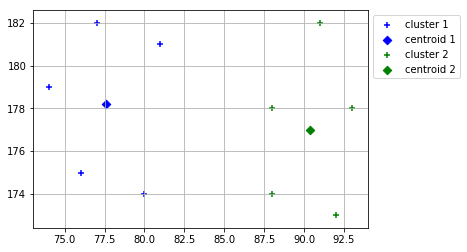

In [10]:
clusters, centers = k_means(samples, k=2) # نستدعي الخورازمية بإدخال البيانات وعدد المجموعات المطلوب 
report_result(clusters, centers)          # عرض النتيجة

<div dir="rtl" lang="ar">
نلاحظ في الأعلى، أن الخوارزمية قامت بتقسيم البيانات إلى مجموعتين اللون الأخضر على اليمين والأزرق على اليسار. ونلاحظ نقاط المنتصف النهائية تقع في منتصف كل مجموعة.
</div>

<div dir="rtl" lang="ar">
إختبار آخر، سنختبر الخوارزمية لتصنف البيانات في ثلاث مجموعات بدل المجموعتين:
</div>

ITER:	init cents: [[74, 179], [77, 182], [81, 181]]
	new cents: [[75.0, 177.0], [77.0, 182.0], [87.6, 177.1]]
ITER:	init cents: [[75.0, 177.0], [77.0, 182.0], [87.6, 177.1]]
	new cents: [[76.7, 176.0], [79.0, 181.5], [90.4, 177.0]]
ITER:	init cents: [[76.7, 176.0], [79.0, 181.5], [90.4, 177.0]]
	new cents: [[76.7, 176.0], [79.0, 181.5], [90.4, 177.0]]


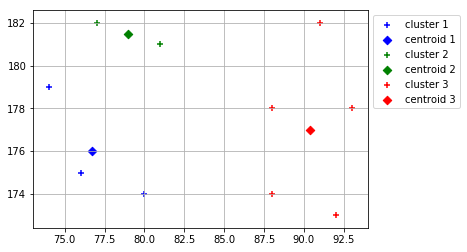

In [11]:
clusters, centers = k_means(samples, k=3)
report_result(clusters, centers)

<div dir="rtl" lang="ar">
بالمثل، نلاحظ في الأعلى ان الخوارزمية قامت بتقسيم البيانات إلى ثلاث مجموعات، اللون الأحمر، الأخضر، والأزرق. وفي المنتصف لكل مجموعة نشاهد نقطة المنتصف التابعة لكل مجموعة.
</div>

<hr>

<div dir="rtl" lang="ar">
في المثال السابق أستخدمنا مجموعة بيانات تحتوي على 10 امثلة فقط و كل مثال يحتوي على خاصيتين أو بُعدين.
</div>

### <div dir="rtl" lang="ar">فيما يلي سنختبر الخوارزمية على مجموعة بيانات أخرى</div>

In [12]:
# ملاحظة: هذا الكود لمجرد إنشاء بيانات وهمية إضافية (من أجل إختبار الخوارزمية) وليس جزء من الشرح، لاتهتم لهذا الكود الآن
# generate a random sample
from random import randint

def random_point(dimension=3):
    return [randint(40, 100) for _ in range(dimension)]

<div dir="rtl" lang="ar">في هذا المثال سننشأ عينة بيانات تحتوي على 200 مثال وكل مثال ذات بعدين: </div>

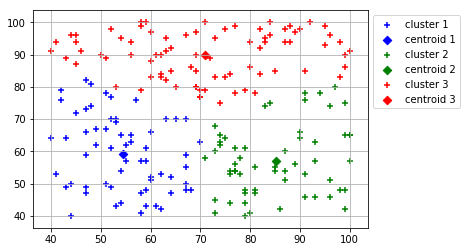

In [13]:
# إنشاء بيانات وهمية أخرى مع 200 مثال
samples2 = [random_point(dimension=2) for _ in range(200)]
# نستدعي الخوارزمية مع البيانات الجديدة و نطلب عدد ثلاث مجموعات
clusters, centers = k_means(samples2, k=3, verbose=False)
report_result(clusters, centers)

<div dir="rtl" lang="ar">
أخيراً، نختبر الخوارزمية مع عينة بيانات تحتوي 700 مثال وكل مثال يحتوي على ثلاثة أبعاد (أي ثلاثية الأبعاد):
</div>

In [14]:
# ملاحظة: هذا الكود لمجرد توضيح البيانات وليس جزء من الشرح، لاتهتم لهذا الكود الآن

# 3D plot
def report_result_3D(clusters, centers):
    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    # create figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # available colors in matplotlib
    n = len(clusters)
    colors = colors[:n]
    
    for i, clus, cent, col in zip(range(1, n+1), clusters, centers, colors):
        ax.scatter([c[0] for c in clus], 
                   [c[1] for c in clus], 
                   [c[2] for c in clus], 
                   marker="4", c=col, label=f"cluster {i}")
        ax.scatter(cent[0], 
                   cent[1], 
                   cent[2], 
                   marker="D", c=col, label=f"centroid {i}")
        
    plt.grid();plt.legend(bbox_to_anchor = (1, 1));plt.show()

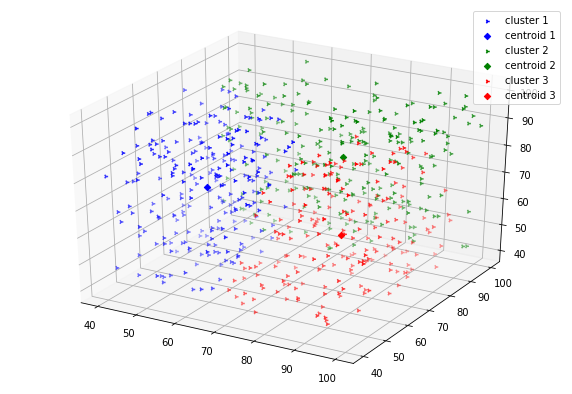

In [15]:
samples3 = [random_point(dimension=3) for _ in range(700)]

clusters, centers = k_means(samples3, k=3, verbose=False)
report_result_3D(clusters, centers)

<hr>

<div style="text-align:right">
إعداد وكتابة: عبدالعزيز الطويان
<br><a href="https://github.com/iamaziz">@iamaziz</a>
<br> رابط لـ <a href="http://aziz.nyc/ar/k_means.slides.html">عرض الشرائح</a>
<br> رابط لـ <a href="http://aziz.nyc/ar/k_means.slides.html">كامل الكود مع التنفيذ</a>
<br>6/15/2019
</div>

<hr>

# مراجع
- http://webpage.pace.edu/aa10212w/course/CS855/hw5-k-means-clustering.html

<hr>

For revealjs rigth-to-left text

In [16]:
%%HTML
<style>div.text_cell_render {text-align: right;}</style>